# Drilling Activity Prediction: Data Modeling - Holt Winters Method

- Import dataset and resample to monthly data
- Use oil dataset to predict oil rig count:
    - Find what hyperparameters to be used in the model (p,d,q)
    - Train/test split
    - Create Exponential Smoothing model and fit with data
    - Generate Forecast and compare against Test set
    - Evaluation Measures
    - Refit the model with 100% of data and make REAL Forecasting    
    
    
 - Create Exponential Smoothing model with Gas dataframe to predict Gas Rig Count

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load specific forecasting tools
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime
from pylab import rcParams
from statsmodels.tsa.holtwinters import SimpleExpSmoothing #for single exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing #for double exponential smoothing
from statsmodels.tools.eval_measures import rmse, mse, meanabs
from sklearn.model_selection import TimeSeriesSplit
import time
from pylab import rcParams

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Size of all plots
rcParams['figure.figsize'] = 6,6

In [2]:
dfoil = pd.read_csv('dfoil.csv',index_col=0,parse_dates=True)
dfoil = dfoil.resample('M').mean()
dfoil.index.freq = 'M'


dfgas = pd.read_csv('dfgas.csv',index_col=0,parse_dates=True)
dfgas = dfgas.resample('M').mean()
dfgas.index.freq = 'M'

In [3]:
"""
This cell is used to evaluate forecasts in different points in time. Basically, the dataset is split to the point we want
so we can make predictions in different scenarios (increasing trend, decreasing trend or lateral behaviors in rig counts)
"""
# dfoil = dfoil[:'2017']          
# dfgas = dfgas[:'2017']

'\nThis cell is used to evaluate forecasts in different points in time. Basically, the dataset is split to the point we want\nso we can make predictions in different scenarios (increasing trend, decreasing trend or lateral behaviors in rig counts)\n'

In [4]:
nobs = 12
train_oil = dfoil.iloc[:len(dfoil)-nobs]
test_oil = dfoil.iloc[len(dfoil)-nobs:] 

In [5]:
oilmodel_exp = ExponentialSmoothing(train_oil['oilrig_count'],trend='add',seasonal='mul',seasonal_periods=nobs).fit()

In [6]:
dfoil_forecast = oilmodel_exp.forecast(nobs)

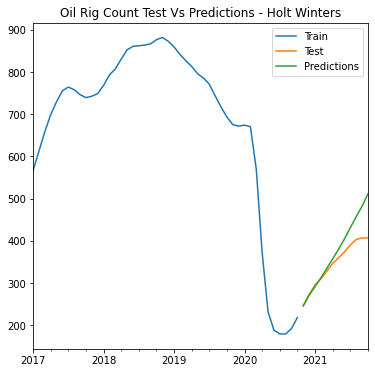

In [7]:
train_oil['oilrig_count'].loc['2017':].plot(legend=True,label='Train',title='Oil Rig Count Test Vs Predictions - Holt Winters')
test_oil['oilrig_count'].plot(legend=True,label='Test')
dfoil_forecast.plot(legend=True,label='Predictions');

In [8]:
RMSE1 = rmse(dfoil['oilrig_count'].loc[test_oil.index.min():],dfoil_forecast)
MSE1 = mse(dfoil['oilrig_count'].loc[test_oil.index.min():],dfoil_forecast)
MAE1 = meanabs(dfoil['oilrig_count'].loc[test_oil.index.min():],dfoil_forecast)

print(f"""Oil Rig VAR(4) RMSE: {RMSE1:.3f}
Oil Rig VAR(4) MSE: {MSE1:.3f}
Oil Rig VAR(4) MAE: {MAE1:.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE1/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

Oil Rig VAR(4) RMSE: 43.342
Oil Rig VAR(4) MSE: 1878.522
Oil Rig VAR(4) MAE: 29.241

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 12.561%


In [9]:
tscv = TimeSeriesSplit(n_splits=10, test_size=12)
RMSE_oil = []
MSE_oil = []
MAE_oil = []
for train_index, test_index in tscv.split(dfoil['oilrig_count']):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    train, test = dfoil['oilrig_count'][train_index], dfoil['oilrig_count'][test_index]
    oilmodel_exp = ExponentialSmoothing(train,trend='add',seasonal='mul',seasonal_periods=nobs).fit()
    dfoil_forecast = oilmodel_exp.forecast(nobs)    
    RMSE_oil.append('{:.3f}'.format(rmse(dfoil['oilrig_count'].loc[test_oil.index.min():],dfoil_forecast)))
    MSE_oil.append('{:.3f}'.format(mse(dfoil['oilrig_count'].loc[test_oil.index.min():],dfoil_forecast)))
    MAE_oil.append('{:.3f}'.format(meanabs(dfoil['oilrig_count'].loc[test_oil.index.min():],dfoil_forecast)))

RMSE_oil = np.array(RMSE_oil).astype('float')
MSE_oil = np.array(MSE_oil).astype('float')
MAE_oil = np.array(MAE_oil).astype('float')
print(f"""\n10-fold Cross Validation Oil Rig
RMSE: {RMSE_oil.mean():.3f},
MSE: {MSE_oil.mean():.3f}
MAE: {MAE_oil.mean():.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE_oil.mean()/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

TRAIN: 178 TEST: 12
TRAIN: 190 TEST: 12
TRAIN: 202 TEST: 12
TRAIN: 214 TEST: 12
TRAIN: 226 TEST: 12
TRAIN: 238 TEST: 12
TRAIN: 250 TEST: 12
TRAIN: 262 TEST: 12
TRAIN: 274 TEST: 12
TRAIN: 286 TEST: 12

10-fold Cross Validation Oil Rig
RMSE: 574.835,
MSE: 501920.060
MAE: 563.763

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 166.592%


In [10]:
test = np.array(RMSE_oil)
test = test.astype('float')

In [11]:
test.mean()

574.8352

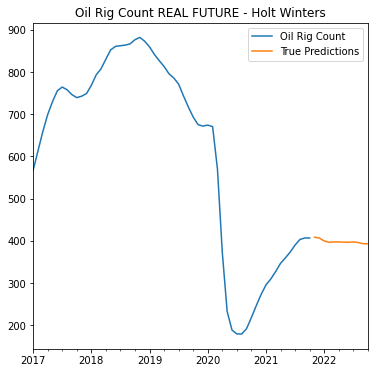

In [12]:
startTime = time.time()
oilmodel_exp = ExponentialSmoothing(dfoil['oilrig_count'],trend='add',seasonal='mul',seasonal_periods=nobs).fit()
dfoil_forecast = oilmodel_exp.forecast(nobs)
executionTime = (time.time() - startTime)
dfoil['oilrig_count'].loc['2017':].plot(legend=True,label='Oil Rig Count', title='Oil Rig Count REAL FUTURE - Holt Winters')
dfoil_forecast.plot(legend=True,label='True Predictions');

In [13]:
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 0.15563702583312988


#### Holts Winter method with Gas dataset

In [14]:
train_gas = dfgas.iloc[:len(dfgas)-nobs]
test_gas = dfgas.iloc[len(dfgas)-nobs:]
gasmodel_exp = ExponentialSmoothing(train_gas['gasrig_count'],trend='add',seasonal='mul',seasonal_periods=nobs).fit()

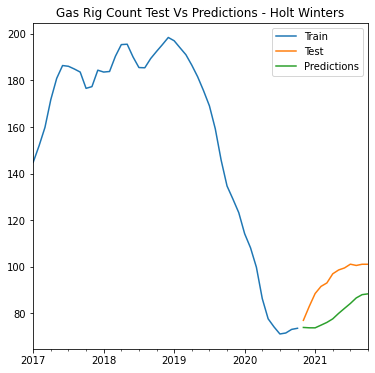

In [15]:
dfgas_forecast = gasmodel_exp.forecast(nobs)
train_gas['gasrig_count'].loc['2017':].plot(legend=True,label='Train',title='Gas Rig Count Test Vs Predictions - Holt Winters')
test_gas['gasrig_count'].plot(legend=True,label='Test')
dfgas_forecast.plot(legend=True,label='Predictions');

In [16]:
RMSE2 = rmse(dfgas['gasrig_count'].loc[test_gas.index.min():],dfgas_forecast)
MSE2 = mse(dfgas['gasrig_count'].loc[test_gas.index.min():],dfgas_forecast)
MAE2 = meanabs(dfgas['gasrig_count'].loc[test_gas.index.min():],dfgas_forecast)

print(f"""Gas Rig VAR(4) RMSE: {RMSE2:.3f}
Gas Rig VAR(4) MSE: {MSE2:.3f}
Gas Rig VAR(4) MAE: {MAE2:.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {RMSE2/dfgas['gasrig_count'][-nobs:].mean()*100:.3f}%""")

Gas Rig VAR(4) RMSE: 15.040
Gas Rig VAR(4) MSE: 226.195
Gas Rig VAR(4) MAE: 14.389

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 15.957%


In [17]:
RMSE_gas = []
MSE_gas = []
MAE_gas = []
for train_index, test_index in tscv.split(dfgas['gasrig_count']):
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    train, test = dfgas['gasrig_count'][train_index], dfgas['gasrig_count'][test_index]
    gasmodel_exp = ExponentialSmoothing(train,trend='add',seasonal='mul',seasonal_periods=nobs).fit()
    dfgas_forecast = gasmodel_exp.forecast(nobs)    
    RMSE_gas.append('{:.3f}'.format(rmse(dfgas['gasrig_count'].loc[test_gas.index.min():],dfgas_forecast)))
    MSE_gas.append('{:.3f}'.format(mse(dfgas['gasrig_count'].loc[test_gas.index.min():],dfgas_forecast)))
    MAE_gas.append('{:.3f}'.format(meanabs(dfgas['gasrig_count'].loc[test_gas.index.min():],dfgas_forecast)))

RMSE_gas = np.array(RMSE_gas).astype('float')
MSE_gas = np.array(MSE_gas).astype('float')
MAE_gas = np.array(MAE_gas).astype('float')
print(f"""\n10-fold Cross Validation Gas Rig
RMSE: {RMSE_gas.mean():.3f},
MSE: {MSE_gas.mean():.3f}
MAE: {MAE_gas.mean():.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {RMSE_gas.mean()/dfgas['gasrig_count'][-nobs:].mean()*100:.3f}%""")

TRAIN: 178 TEST: 12
TRAIN: 190 TEST: 12
TRAIN: 202 TEST: 12
TRAIN: 214 TEST: 12
TRAIN: 226 TEST: 12
TRAIN: 238 TEST: 12
TRAIN: 250 TEST: 12
TRAIN: 262 TEST: 12
TRAIN: 274 TEST: 12
TRAIN: 286 TEST: 12

10-fold Cross Validation Gas Rig
RMSE: 196.514,
MSE: 83168.085
MAE: 193.324

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 208.493%


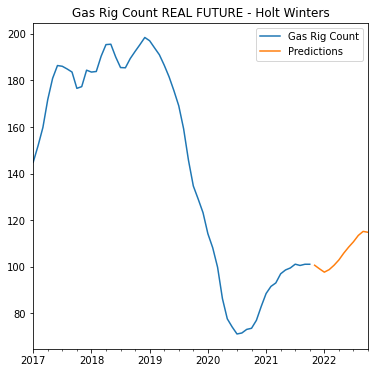

In [18]:
gasmodel_exp = ExponentialSmoothing(dfgas['gasrig_count'],trend='add',seasonal='mul',seasonal_periods=nobs).fit()
dfgas_forecast = gasmodel_exp.forecast(nobs)
dfgas['gasrig_count'].loc['2017':].plot(legend=True,label='Gas Rig Count',title='Gas Rig Count REAL FUTURE - Holt Winters')
dfgas_forecast.plot(legend=True,label='Predictions');